In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

In [4]:
n_process = 8

# load data

In [5]:
data_dir = 'data'

In [6]:
i_sim = 0

In [7]:
data_network = pd.read_feather('%s/network.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir,i_sim))

In [8]:
n_node = len(data_feature)
n_edge = len(data_network)

In [9]:
data_network

,row,col
0,1,2311
1,1,3144
2,1,3568
3,1,3603
4,2,2146
...,...,...
9917,3999,3227
9918,4000,279
9919,4000,2085
9920,4000,3306


In [10]:
data_feature

,X1,X2,X3,W1,W2,W3,p,T,m,Y
0,0,1,1,-0.25,0.25,-0.25,0.500000,1,0.622459,0
1,0,0,1,0.25,-0.25,-0.25,0.222700,1,0.904651,1
2,1,0,0,-0.25,0.25,-0.25,0.544525,0,0.320821,1
3,0,1,1,-0.25,0.25,-0.25,0.651355,1,0.407333,1
4,1,1,1,0.25,0.25,0.25,0.500000,1,0.622459,1
...,...,...,...,...,...,...,...,...,...,...
3995,0,1,0,-0.25,-0.25,0.25,0.500000,1,0.622459,0
3996,1,1,0,0.25,-0.25,-0.25,0.500000,0,0.377541,0
3997,0,1,0,-0.25,-0.25,0.25,0.222700,0,0.777300,1
3998,0,0,0,0.25,0.25,0.25,0.777300,1,0.222700,0


In [11]:
Adj = sparse.csr_matrix((
    np.full(n_edge, True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [12]:
G = KECENI.Graph(Adj)

In [13]:
Ys = data_feature.iloc[:,9].values
Ts = data_feature.iloc[:,7].values
Xs = data_feature.iloc[:,3:6].values

In [14]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [15]:
from hyperparams import delta

# counterfactual of interest

In [ ]:
i0s = np.arange(0,n_node,10)

In [ ]:
T0s_0 = np.full(n_node, 0)
T0s_1 = np.full(n_node, 1)

In [18]:
T0s = np.stack([T0s_0, T0s_1], 0)

# groundtruth

In [19]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [20]:
from true_model import mu, pi, rX

In [21]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [22]:
true_fit = true_model.fit(data, n_X=None)

In [ ]:
result_true = true_fit.G_estimate(
    i0s[:,None], T0s, n_X=10000
)

In [24]:
YTRs_0, YTRs_1 = np.moveaxis(result_true, -1, 0)
YTRds = YTRs_1 - YTRs_0

In [25]:
EYTR_0 = np.mean(YTRs_0)
EYTR_1 = np.mean(YTRs_1)
EYTR_d = EYTR_1 - EYTR_0

In [26]:
EYTR_0, EYTR_1, EYTR_d

(0.40596511817641956, 0.5941699778249249, 0.1882048596485053)

(array([ 49.,  34.,   0.,   0.,   5., 107.,  70.,  88.,  18.,  29.]),
 array([0.11582571, 0.12873501, 0.1416443 , 0.1545536 , 0.16746289,
        0.18037219, 0.19328148, 0.20619078, 0.21910007, 0.23200937,
        0.24491866]),
 <BarContainer object of 10 artists>)

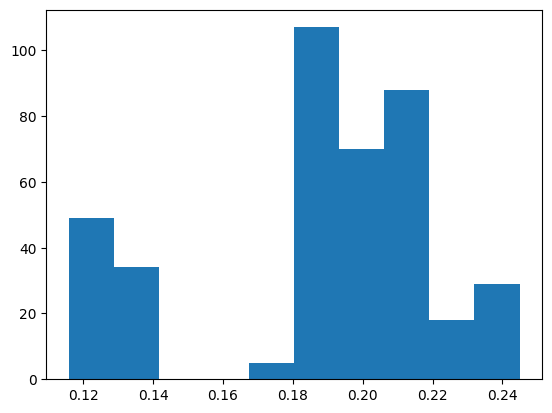

In [27]:
plt.hist(YTRds)

# estimation

In [28]:
from KECENI.RegressionModel import LogisticRegressionModel
from KECENI.PropensityModel import LogisticIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [29]:
from hyperparams import summary_mu, summary_pi

In [30]:
keceni_model = KECENI.Model(
    LogisticRegressionModel(summary_mu),
    LogisticIIDPropensityModel(summary_pi),
    IIDCovariateModel(),
    delta
)

In [31]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm)

fit: 100%|██████████| 4000/4000 [02:24<00:00, 27.75it/s]


## - cross-validation

In [32]:
lamdas = np.linspace(0, 20, 21)[1:]

In [ ]:
result_cv = keceni_fit.cv(
    i0s=i0s, tqdm=tqdm
)

cv: 100%|██████████| 4000/4000 [02:46<00:00, 24.01it/s]


In [34]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

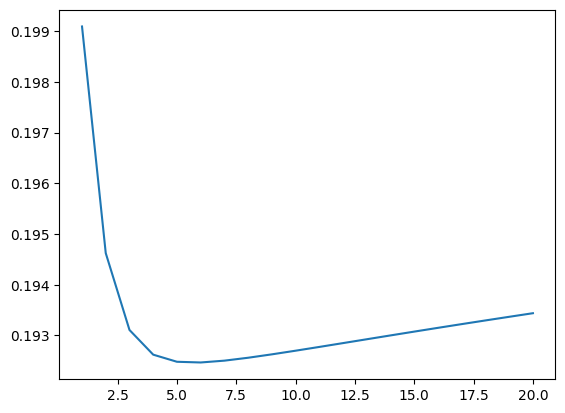

In [35]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [36]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

5

In [37]:
# id_cv = 3

In [38]:
lamdas[id_cv]

6.0

## - G estimate

In [ ]:
result_G = keceni_fit.G_estimate(
    i0s[:,None], T0s, n_X=1000,
    tqdm=tqdm, level_tqdm=0
)

i0: 100%|██████████| 800/800 [00:15<00:00, 52.35it/s]


In [46]:
YGs_0, YGs_1 = np.moveaxis(result_G, -1, 0)
YGs_d = YGs_1 - YGs_0

In [47]:
EYG_0 = np.mean(YGs_0)
EYG_1 = np.mean(YGs_1)
EYG_d = EYG_1 - EYG_0

In [48]:
EYG_1, EYG_0, EYG_d

(0.602373349868897, 0.39446448509869597, 0.20790886477020104)

(array([13., 34., 21., 13.,  3., 21., 80., 76., 92., 47.]),
 array([0.09737704, 0.1144122 , 0.13144737, 0.14848254, 0.1655177 ,
        0.18255287, 0.19958804, 0.2166232 , 0.23365837, 0.25069354,
        0.2677287 ]),
 <BarContainer object of 10 artists>)

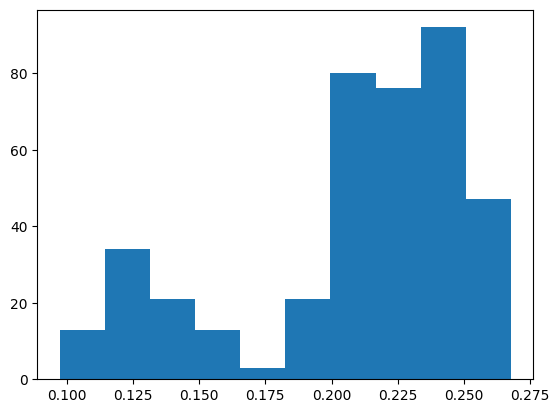

In [49]:
plt.hist(YGs_d)

## - DR estimate

In [ ]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s[:,None], T0s, tqdm=tqdm
)

AIPW: 100%|██████████| 4000/4000 [02:49<00:00, 23.64it/s]


In [53]:
YDRs_0, YDRs_1 = np.moveaxis(result_AIPW.est(lamdas)[id_cv], -1, 0)
YDRs_d = YDRs_1 - YDRs_0

In [54]:
EYDR_0 = np.mean(YDRs_0)
EYDR_1 = np.mean(YDRs_1)
EYDR_d = EYDR_1 - EYDR_0

In [55]:
EYDR_0, EYDR_1, EYDR_d

(0.41090708735860304, 0.620407303457065, 0.20950021609846192)

(array([ 29.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 371.]),
 array([0.19786732, 0.19912154, 0.20037576, 0.20162998, 0.2028842 ,
        0.20413842, 0.20539264, 0.20664686, 0.20790108, 0.20915531,
        0.21040953]),
 <BarContainer object of 10 artists>)

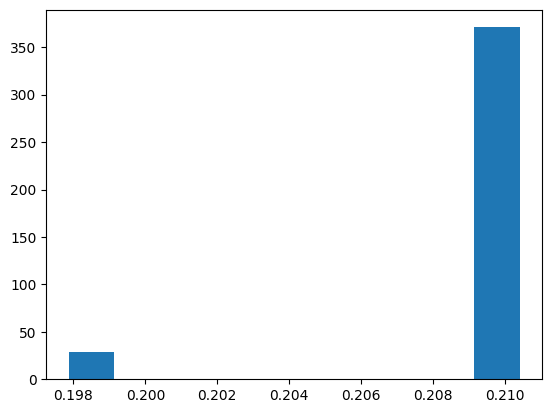

In [56]:
plt.hist(YDRs_d)